# TP1 - EDP/Options européennes

Nom Prenom : FEKNOUS Rostane 

# Import des librairies :

In [1]:
import numpy as np # array
import numpy.linalg as lng # linear algebra
import matplotlib.pyplot as plt # plot functions
import time
import sys # command sys.exit()
import pandas as pd
import scipy.stats as sc
from scipy.sparse import csr_matrix, eye, diags
from scipy.sparse.linalg import spsolve
import warnings
warnings.filterwarnings('ignore')

# Partie I - Implémentation des schémas de dérivation  :

## Résumé Explicatif du Contexte et de l'Objectif

Le code présenté dans cette partie du notebook Rmd définit une classe nommée `Schema`, conçue pour modéliser et résoudre des problèmes numériques, vraisemblablement dans le domaine de la finance quantitative, tels que le pricing d'options ou d'autres instruments financiers. L'objectif principal est de mettre en œuvre une méthode numérique pour évaluer des produits dérivés sous certaines hypothèses de marché, en utilisant des techniques de différences finies. La classe `Schema` permet de simuler l'évolution du prix d'un sous-jacent (comme une action ou un indice) et d'évaluer le prix d'une option en fonction de ce sous-jacent, à travers différentes méthodes de résolution.

## Structure de Code Expliquée

### 1. Paramètres Généraux et Vecteurs/Matrices
- **Paramètres Généraux** : La classe débute par la définition de paramètres numériques (`r`, `sigma`, `K`, `T`, `N`, `I`, `Smin`, `Smax`, `h`, `dt`, `SCHEME`), qui représentent respectivement le taux d'intérêt sans risque, la volatilité, le prix d'exercice de l'option, la maturité, le nombre de pas dans le temps, le nombre de pas dans l'espace, les bornes inférieure et supérieure du sous-jacent, le pas d'espace, le pas de temps et le type de schéma numérique utilisé.
- **Vecteurs/Matrices** : Les vecteurs et matrices (`A`, `U`, `Q`, `s`) sont initialisés mais non définis, destinés à être utilisés pour stocker les coefficients et les solutions du système d'équations.

### 2. Constructeur
- Le constructeur initialise les paramètres de l'instance avec les valeurs données et calcule des paramètres dérivés tels que `h` et `dt`.
- Il prépare également le vecteur `s` qui représente les valeurs possibles du sous-jacent et calcule les coefficients nécessaires pour la matrice `A`.

### 3. Méthodes Principales
- `u0`, `uleft`, `uright` : Ces méthodes définissent les conditions initiales et aux limites pour le problème.
- `q` : Calcule un vecteur source basé sur les conditions aux limites.

### 4. Méthodes Spécifiques
- `compute` : Implémente les différents schémas numériques pour résoudre le problème (Euler explicite, Euler implicite, Crank-Nicolson) et met à jour la solution `U`.
- `Interpolate` : Permet d'interpoler la solution à une valeur spécifique du sous-jacent.
- `create_convergence_table` : Crée un tableau de convergence pour évaluer la performance de la méthode numérique en comparant les résultats avec une solution exacte.

En résumé, la classe `Schema` est une structure conçue pour évaluer des equations aux dérivées partielles en utilisant les méthodes numériques spécifiées. Elle est flexible pour permettre l'utilisation de différents schémas de différences finies et est optimisée pour évaluer l'efficacité et la précision des méthodes implémentées.


In [2]:
class Schema :
    
    ## Définition des paramètres numériques généraux : 
    r = 0
    sigma = 0
    K = 0
    T = 0
    N = 0
    I = 0.5
    Smin = 0
    Smax = 0
    h = 0
    dt = 0
    SCHEME = ''

    # Vecteurs/Matrices du système : 

    A = None
    U = None
    Q = None
    s = None
    
    
    
    # Constructeur : 
    def __init__(self, r, sigma, K, T, N, I, Smin, Smax, SCHEME):
        #Instance paramètres du constructeur:
        self.r = r
        self.sigma = sigma
        self.K = K
        self.T = T
        self.N = N
        self.I = I
        self.Smin = Smin
        self.Smax = Smax
        self.SCHEME = SCHEME
        self.h = (Smax-Smin)/(I+1)
        self.dt = T/N
        
        #Instance Sous jacent et coefficients de A:
        self.s = Smin + self.h*np.arange(1,self.I+1)
        self.alpha = 0.5*(sigma**2)*(self.s**2)/(self.h**2)
        self.beta = r*self.s/(2*self.h)
        
        #Instance des matrices du système:
        self.A = np.zeros((self.I,self.I))
        self.U = np.zeros((self.I,1))
        self.Q = np.zeros((self.I,1))

    # Méthodes principales : 

    def u0(self, s):
        return np.maximum(self.K-s,0).reshape(self.I,1)

    def uleft(self, tn):
        return self.K*np.exp(-self.r*tn) - self.Smin

    def uright(self, tn):
        return 0
    
    def q(self, tn):
        self.Q[0] = (-self.alpha[0] + self.beta[0]) * self.uleft(tn)
        self.Q[-1] = -(self.alpha[-1] - self.beta[-1]) * self.uright(tn)
        return self.Q
    
    # Méthodes spécifiques
    
    def compute(self, sparse_Bool = False):        
        diag_centrale  = 2*self.alpha + self.r
        diag_inferieure = (-self.alpha + self.beta)[1:]
        diag_superieure = -(self.alpha + self.beta)[:-1]
        
        diagonals = [diag_inferieure, diag_centrale, diag_superieure]
        offsets = [-1, 0, 1]  # décalages par rapport à la diagonale principale
        
        if sparse_Bool:
            # Utilisation de sparse pour créer une matrice creuse
            I = self.I  # The size of the matrix

            # Create arrays for data and row/column indices
            data = []
            row = []
            col = []

            # Lower diagonal
            for i in range(1, I):
                data.append(diag_inferieure[i - 1])
                row.append(i)
                col.append(i - 1)

            # Main diagonal
            for i in range(I):
                data.append(diag_centrale[i])
                row.append(i)
                col.append(i)

            # Upper diagonal
            for i in range(I - 1):
                data.append(diag_superieure[i])
                row.append(i)
                col.append(i + 1)

            # Create the csr_matrix
            self.A = csr_matrix((data, (row, col)), shape=(I, I))
        else:
            self.A = self.A + np.diag(diag_inferieure,-1) + np.diag(diag_centrale,0) + np.diag(diag_superieure,1)

        
        self.U = self.u0(self.s)
        if (self.SCHEME == "EE"):
            clr = 'blue'
            for n in range(0,self.N):
                t = n*self.dt
                self.U = self.U - self.dt*(self.A @ self.U + self.q(t))
            
        if (self.SCHEME == "EI"):
            clr = 'orange'
            if sparse_Bool:
                A_implicit = eye(self.I, format = "csr") + self.dt*self.A
            else: 
                A_implicit = np.eye(self.I) + self.dt*self.A
            for n in range(0,self.N):
                t = n*self.dt
                if sparse_Bool :
                    self.U = spsolve(A_implicit, self.U - self.dt * self.q(t + self.dt)).reshape(-1,1)
                else:
                    self.U = np.linalg.solve(A_implicit, self.U - self.dt * self.q(t + self.dt)).reshape(-1,1)              
            
        if (self.SCHEME == "CN"):
            clr = 'red'
            if sparse_Bool:
                A_imp_Nicolson = eye(self.I, format = "csr") - 0.5*self.dt*self.A
                A_Nicolson = eye(self.I, format = "csr") + 0.5*self.dt*self.A
            else:
                A_imp_Nicolson = np.eye(self.I) - 0.5*self.dt*self.A
                A_Nicolson = np.eye(self.I) + 0.5*self.dt*self.A
            for n in range(0,self.N):
                t = n*self.dt
                if sparse_Bool :
                    self.U = spsolve(A_Nicolson, A_imp_Nicolson @ self.U - 0.5*self.dt*(self.q(t) + self.q(t + self.dt))).reshape(-1,1)
                else:
                    self.U = np.linalg.solve(A_Nicolson, A_imp_Nicolson @ self.U - 0.5*self.dt*(self.q(t) + self.q(t + self.dt))).reshape(-1,1) 
        
    
    def Interpolate(self, s_barre):
        for i, s in enumerate(self.s):
            if s <= s_barre <= (s + self.h):
                return (((self.s[i+1] - s_barre) * self.U[i] + (s_barre - self.s[i]) * self.U[i+1]) / self.h)[0]

    def create_convergence_table(self, s_barre, exact_solution_func, method_N, sparse_Bool = False):
        rng = [10, 20, 40, 80, 160, 320]
        I_N_Values = [(i, method_N(i)) for i in rng]
        Interpolated_values = np.zeros(len(rng))
        error = np.zeros(len(rng))
        alpha = np.zeros(len(rng))
        errex = np.zeros(len(rng))
        tcpu = np.zeros(len(rng))
        
        exact_sol = exact_solution_func(self.K, self.T, self.r, self.sigma, s_barre)
        previous_value = None
        previous_h = None
        
        for index, (I, N) in enumerate(I_N_Values):
            start_time = time.time()
            schema = Schema(self.r, self.sigma, self.K, self.T, N, I, self.Smin, self.Smax, self.SCHEME)
            schema.compute(sparse_Bool)
            tcpu[index] = time.time() - start_time
            
            # Calcul des interpolations et des erreurs
            interpolated = schema.Interpolate(s_barre)
            Interpolated_values[index] = interpolated
            error[index] = np.absolute(previous_value - interpolated) if index > 0 else 0
            errex[index] = np.absolute(interpolated - exact_sol) if index > 0 else 0
            alpha[index] = np.log(error[index-1]/error[index]) / np.log(previous_h/schema.h) if index > 1 else 0
            
            previous_value = interpolated
            previous_h = schema.h

        cv_table = pd.DataFrame({'I': [i[0] for i in I_N_Values],
                                 'N': [i[1] for i in I_N_Values],
                                 'U(s)': Interpolated_values,
                                 'error': error,
                                 'alpha': alpha,
                                 'errex': errex,
                                 'tcpu': tcpu})
        return cv_table


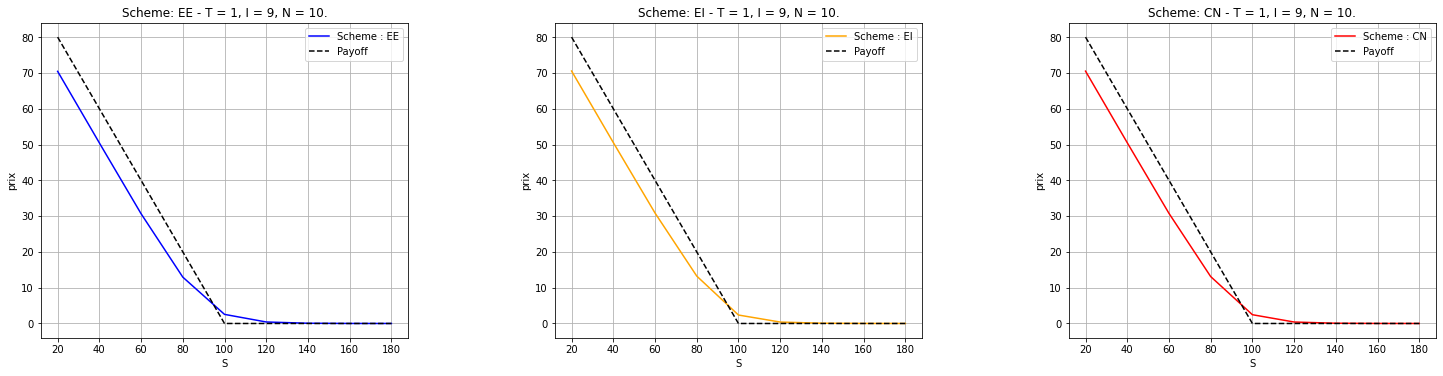

In [3]:
r = 0.1
sigma = 0.2
K = 100
T = 1
N = 10
I = 9
Smin = 0
Smax = 200
SCHEMES = ['EE', 'EI', 'CN']
clr = ['blue', 'orange', 'red']
fig, axes = plt.subplots(1, 3, figsize=(25, 5))

for i, SCHEME in enumerate(SCHEMES):
    test = Schema(r, sigma, K, T, N, I, Smin, Smax, SCHEME)
    test.compute()
    
    axes[i].plot(test.s, test.U, label=f'Scheme : {SCHEME}', color = clr[i])
    axes[i].plot(test.s, test.u0(test.s), 'k--', label='Payoff')
    axes[i].set_title(f'Scheme: {SCHEME} - T = {T}, I = {I}, N = {N}.')
    axes[i].set_xlabel('S')
    axes[i].set_ylabel('prix')
    axes[i].legend()
    axes[i].grid(True)

plt.subplots_adjust(top=1.0, wspace=0.4)
plt.show()

# Numerical tests : 

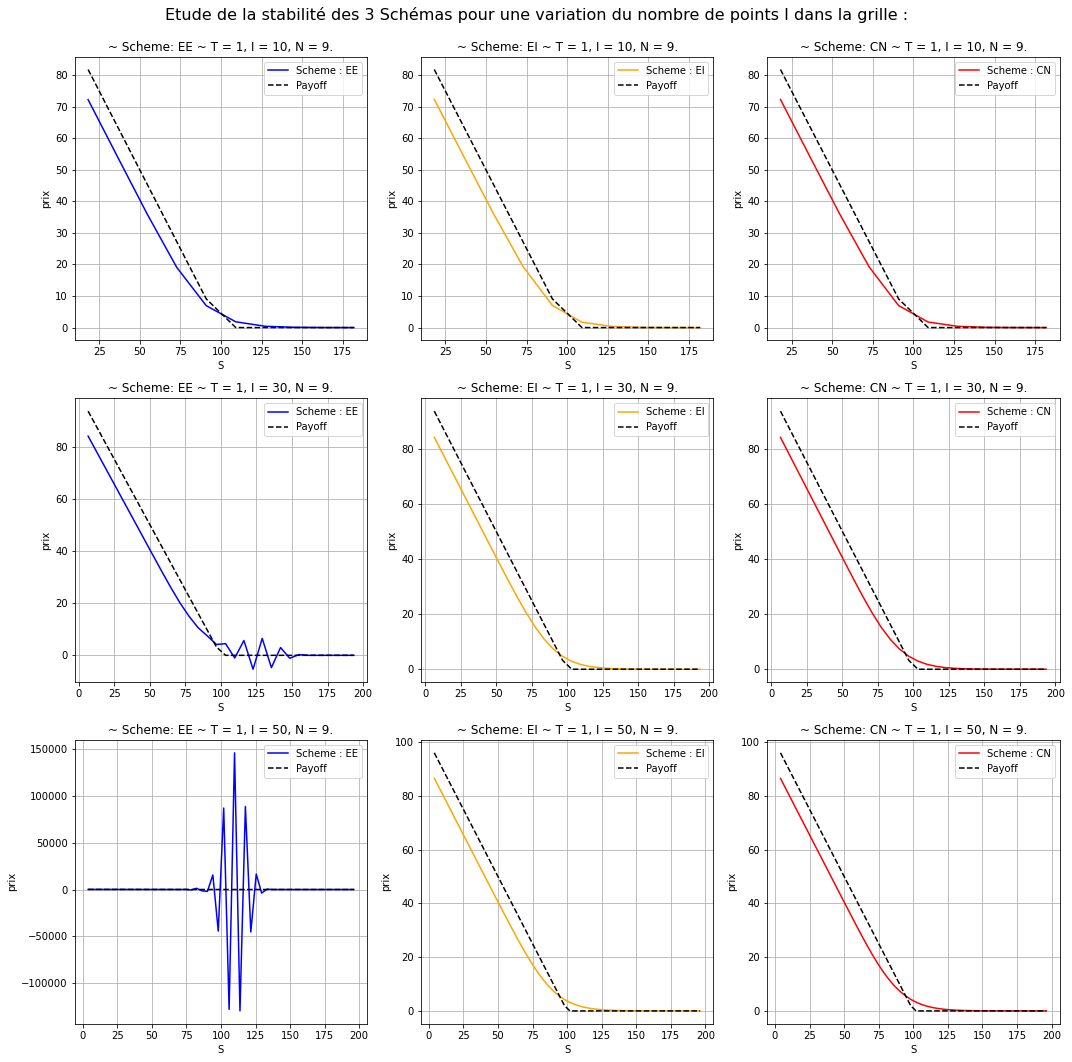

---- Caractéristiques pour I = 10 ----
  <o> Schéma : EE
    - Positivité des termes diagonaux : Oui
    - Norme 2 : 0.985
    - Norme infinie : 0.993
    - Cinq derniers termes diagonaux en norme : [0.82888889 0.77111111 0.70444444 0.62888889 0.54444444]
    - µ (CFL) = 0.538

  <o> Schéma : EI
    - Positivité des termes diagonaux : Oui
    - Norme 2 : 0.986
    - Norme infinie : 0.993
    - Cinq derniers termes diagonaux en norme : [0.86123334 0.82591116 0.79008478 0.75422061 0.70066928]
    - µ (CFL) = 0.538

  <o> Schéma : CN
    - Positivité des termes diagonaux : Oui
    - Norme 2 : 0.986
    - Norme infinie : 0.993
    - Cinq derniers termes diagonaux en norme : [0.8469706  0.80268782 0.75534062 0.70583032 0.63980386]
    - µ (CFL) = 0.538

-----------------------------------------

---- Caractéristiques pour I = 30 ----
  <o> Schéma : EE
    - Positivité des termes diagonaux : Non
    - Norme 2 : 5.682
    - Norme infinie : 6.487
    - Cinq derniers termes diagonaux en norme :

In [4]:
import matplotlib.pyplot as plt
import numpy as np

N = 9
B = [[],[],[]]
µ = [[],[],[]]
Interpolated = [[],[],[]]
s̄ = 80
SCHEMES = ['EE', 'EI', 'CN']
theta = [0, 1, 1/2]
clr = ["blue","orange","red"]
I_range = [10*i for i in range(1, 6, 2)]

fig, axs = plt.subplots(len(I_range), len(SCHEMES), figsize=(15, len(I_range)*5))


for i, I in enumerate(I_range):
    for j, SCHEME in enumerate(SCHEMES):
        test = Schema(r, sigma, K, T, N, I, Smin, Smax, SCHEME)
        test.compute()
        
        # Preparation des matrices de paramètres pour la suite
        #B[i].append(np.linalg.inv(np.eye(I) + theta[j]*test.dt*test.A)*(np.eye(I) - (1 - theta[j])*test.dt*test.A))
        B[i].append(np.linalg.solve(np.eye(I) + theta[j]*test.dt*test.A,np.eye(I) - (1 - theta[j])*test.dt*test.A))
        µ[i].append(test.dt*((test.sigma*test.Smax/test.h)**2))
        Interpolated[j].append(test.Interpolate(s̄))
        
        axs[i, j].plot(test.s, test.U, label=f'Scheme : {SCHEME}', color = clr[j])
        axs[i, j].plot(test.s, test.u0(test.s), 'k--', label='Payoff')
        axs[i, j].set_title(f'~ Scheme: {SCHEME} ~ T = {T}, I = {I}, N = {N}.')
        axs[i, j].set_xlabel('S')
        axs[i, j].set_ylabel('prix')
        axs[i, j].legend()
        axs[i, j].grid(True)
        
fig.suptitle('Etude de la stabilité des 3 Schémas pour une variation du nombre de points I dans la grille :\n', fontsize=16)
plt.tight_layout()
plt.show()


# Affichage des caractéristiques pour chaque I et chaque schéma
for i in range(len(I_range)): # 10, 30, 50
    print(f"---- Caractéristiques pour I = {I_range[i]} ----")

    for j, SCHEME in enumerate(SCHEMES): # [EE, EI, CM]
        b = B[i][j]  # Obtenir la matrice d'amplification pour I et le schéma correspondant
        Positivité_des_termes_diagonaux = np.mean(np.diag(b) > 0) > 0.90

        print(f"  <o> Schéma : {SCHEME}")
        print(f"    - Positivité des termes diagonaux : {'Oui' if Positivité_des_termes_diagonaux else 'Non'}")
        print(f"    - Norme 2 : {round(lng.norm(b,2),3)}")
        print(f"    - Norme infinie : {round(lng.norm(b,np.inf),3)}")
        print(f"    - Cinq derniers termes diagonaux en norme : {np.absolute(np.diag(b))[-5:]}")
        print(f"    - µ (CFL) = {round(µ[i][j],3)}")
        #print(f"    - U(s̄) = {Interpolated[i][j]}")
        print()

    print("-----------------------------------------\n")

## Interprétation relatives à la stabilité dans un Schéma Numérique

### 1. Positivité des termes diagonaux de la matrice d'amplification
- La **matrice d'amplification** est utilisée dans l'analyse de la stabilité des schémas numériques, indiquant comment les erreurs ou perturbations sont amplifiées à chaque étape. Elle permet de caractériser l'équation de propagation de l'erreur.
- Des **termes diagonaux positifs** peuvent suggérer une stabilité du schéma pour certaines conditions initiales ou types de problèmes, et être associés à la conservation de certaines propriétés physiques ou mathématiques.

On observe dans l'echantillon de matrice d'amplification affiché que les coefficients sont absolument supérieurs à 1 lorsque s'illustre l'instabilité.

### 2. Norme 2 de la matrice d'amplification
- La **norme 2** ou norme spectrale, est la valeur propre maximale de la matrice d'amplification.
- Elle mesure l'amplification maximale d'une erreur dans le schéma. Une norme supérieure à 1 indique que les erreurs peuvent croître, menant potentiellement à l'instabilité. Cette condition sur la norme 2 est la condition de Von Neumann :  
$$
|\lambda_{max}| \leq 1
$$

où $\lambda_{max}$ est la valeur propre de plus grande magnitude de la matrice d'amplification du schéma. Si cette condition est respectée, le schéma est dit stable.

La stabiltié inconditionnelle au sens de Von Neumann lorsque $ \theta \in [0,1/2] $ est clairement illustrée dans le cas échéant. Pour un CFL au demeurant élevé on observe que les schemas EI et CN sont inconditionnellement stables. Inversement, on constate qu'après un nombre fini d'itérations, la norme de la matrice d'amplification du schema EE est grandement supérieure à 1. 

### 3. Norme infinie de la matrice d'amplification
- La **norme infinie** est le maximum absolu des sommes des lignes de la matrice.
- Elle fournit une mesure de l'amplification maximale que pourrait subir une erreur sur une étape donnée. Comme pour la norme 2, une valeur supérieure à 1 peut indiquer un risque d'instabilité.

Dans notre cas, la stabilité pour la norme infinie de la matrice d'amplification (à une erreur numérique près) est également illustrée. On observe une croissance explosive de la norme pour le schema EE qui conforte l'instabilité constatée. En revanche, on observe que la matrice d'amplification est bornée pour EI et CN. 

### 4. CFL (Condition de Courant-Friedrichs-Lewy)
- La **condition de CFL** est un critère de stabilité pour les schémas numériques en équations aux dérivées partielles, surtout de type hyperbolique.
- Elle établit une relation entre le pas de temps, le pas d'espace et la vitesse maximale de propagation des ondes. Pour garantir la stabilité, le pas de temps doit être suffisamment petit pour que l'information ne traverse pas plus d'une cellule spatiale par étape temporelle.

Dans le cas échéant, une corrélation entre faible valeur du CFL et stabilité. En effet, pour EE (I = 10, N = 10), on observe une valeur faible, qui augmente grandement par la suite lorsque I augmente et que l'on constate une instabilité fortement illustrée.

$$
\Delta t \leq \frac{C \cdot \Delta x}{u_{max}}
$$

où :
- $\Delta t$ est le pas de temps.
- $\Delta x$ est le pas d'espace.
- $u_{max}$ est la vitesse maximale de propagation (par exemple, la vitesse des ondes ou des fluides dans le système).
- $C$ est le nombre de CFL, généralement inférieur ou égal à 1 pour la stabilité.


On constate par ailleurs une cohérence graphique qui illustre le respect ou non des conditions numériques de stabilité. En effet, on observe visuellement l'instabiltié du schéma d'Euler Explicite illustrée au fur et à mesure que la grille spaciale caractérisée par I augmente. Inversement, la stabilité de EI et CN sont également clairement visibles.

De surcroit, on observe graphiquement que la courbe est de plus en plus lisse au fur et à mesure que la grille s'affine. 

# Tables de convergence et compléments  : 

In [5]:
def BS_put(K,T,r,sigma,S):
    d1 = (np.log(S/K)+(r+sigma**2/2))*T/(sigma*T)
    d2 = (np.log(S/K)+(r-sigma**2/2))*T/(sigma*T)
    
    return -S*sc.norm.cdf(-d1) + K*np.exp(-r*T)*sc.norm.cdf(-d2)

def N_form_1(x):
    return int(x)

def N_form_2(x):
    return int(x*x/10)

def N_form_3(x):
    return int(x/10)

## Tables de convergence EE, EI, CN : 

In [6]:
s̄ = 80
SCHEMES = ['EE', 'EI', 'CN']

for scheme in SCHEMES:
    # Select the appropriate N_form based on the scheme
    if scheme == 'EE':
        N_form1 = N_form_1
        N_form2 = N_form_2
        I_form = "I²/10"
    else:
        N_form1 = N_form_1
        N_form2 = N_form_3
        I_form = "I/10"
        
    schema = Schema(r, sigma, K, T, N, I, Smin, Smax, scheme)
    convergence_table_1 = schema.create_convergence_table(s̄, BS_put, N_form1)
    convergence_table_2 = schema.create_convergence_table(s̄, BS_put, N_form2)
    
    print('\t----------------------------------------------------------------------------------------------')
    print(f"\t > ------------- Etude de convergence/stabiltié spaciale pour le schema '{scheme}' ------------- <")
    print('\t----------------------------------------------------------------------------------------------\n')
    print(f"> Table de convergence pour le Schéma {scheme} |  N = I ; s̄ = {s̄}:\n\n{convergence_table_1}\n\n")
    print(f"> Table de convergence pour le Schéma {scheme} |  N ~ {I_form} - s̄ = {s̄}:\n\n{convergence_table_2}\n\n")

	----------------------------------------------------------------------------------------------
	 > ------------- Etude de convergence/stabiltié spaciale pour le schema 'EE' ------------- <
	----------------------------------------------------------------------------------------------

> Table de convergence pour le Schéma EE |  N = I ; s̄ = 80:

     I    N          U(s)         error       alpha         errex      tcpu
0   10   10  1.425509e+01  0.000000e+00    0.000000  0.000000e+00  0.000000
1   20   20  1.351532e+01  7.397757e-01    0.000000  2.416537e-01  0.001000
2   40   40  1.332033e+01  1.949874e-01    1.992995  4.666637e-02  0.001966
3   80   80 -1.061474e+04  1.062806e+04  -16.017683  1.062801e+04  0.002027
4  160  160 -8.121408e+69  8.121408e+69 -220.831897  8.121408e+69  0.005001
5  320  320           NaN           NaN         NaN           NaN  0.011966


> Table de convergence pour le Schéma EE |  N ~ I²/10 - s̄ = 80:

     I      N       U(s)     error     alpha     er

## Analyse des Tables de Convergence pour le Schéma EE

### Table de convergence avec N = I:
- **Convergence**: L'erreur ne diminue pas de manière cohérente avec l'augmentation de la résolution de la grille (I), indiquant une possible instabilité numérique pour les grilles plus fines. On constate une croissance brutale à partir N=I=80 qui tend à la divergence.
- **Facteur d'amplification (α)**: Ce facteur représente comment les erreurs sont amplifiées à chaque étape du temps. L'instabilité est également suggérée par le fait que $\alpha $ devient non numérique (NaN) pour les valeurs plus élevées de I  indiquant une perte de contrôle sur l'amplification de l'erreur - encore un signe d'instabilité.
- **Temps CPU (tcpu)**: L'augmentation du temps CPU avec I est attendue, mais l'efficacité du calcul est remise en question par l'absence de réduction correspondante de l'erreur.

### Table de convergence avec $N = I²/10$:
- **Convergence**: L'erreur semble décroître lorsque I augmente, ce qui indique une meilleure convergence et stabilité, probablement grâce à un respect accru de la condition CFL.
- **Facteur d'amplification (α)**: Les valeurs de $\alpha$ restent stables et proches de 1, ce qui montre un contrôle sur l'amplification de l'erreur.
- **Temps CPU (tcpu)**: Bien que le temps de calcul augmente plus rapidement dû à la relation quadratique entre N et I, cette augmentation est justifiée par l'amélioration de la précision.

## Analyse des Tables de Convergence pour le Schéma EI :

### Schéma EI avec N = I :
- **Convergence**: Pour de faibles valeurs de I, l'erreur est faible, ce qui est attendu. Cependant, une augmentation significative de l'erreur se produit pour I=80, ce qui pourrait indiquer une instabilité ou une inadéquation du schéma à cette taille de grille.
- **Facteur d'amplification (α)**: La valeur de $\alpha$ augmente avec I, ce qui pourrait indiquer une amplification accrue des erreurs. Pour I=80, la valeur de $\alpha$ excède 1, ce qui est un signe clair d'instabilité.
- **Temps CPU (tcpu)**: Le temps de calcul augmente avec I, comme prévu, mais la corrélation entre le temps CPU et la précision des résultats n'est pas linéaire, ce qui souligne l'importance d'une analyse coût-bénéfice lors du choix de la taille de grille.

### Schéma EI avec N = I/10 :
- **Convergence**: L'erreur décroît avec l'augmentation de I, ce qui indique que le schéma EI est plus stable et précis avec un pas de temps plus petit en proportion du pas spatial, comme le prévoit la condition CFL.
- **Facteur d'amplification (α)**: Les valeurs de $\alpha$ restent proches de 1, confirmant la stabilité du schéma dans cette configuration.
- **Temps CPU (tcpu)**: L'augmentation proportionnelle du temps de calcul par rapport à I² est observée, mais elle est justifiée par la précision améliorée des résultats.

## Analyse des Tables de Convergence pour le Schéma CN :

### Schéma CN avec N = I:
- **Convergence**: L'erreur reste faible pour les petites valeurs de I, mais une augmentation notable de l'erreur pour I=80 suggère des limites à la stabilité du schéma CN pour cette configuration.
- **Facteur d'amplification (α)**: Bien que les valeurs de $\alpha$ restent proches de 1 pour les petites grilles, pour I=80, $\alpha$ devient supérieur à 1, suggérant une possible instabilité.
- **Temps CPU (tcpu)**: L'augmentation du temps CPU est notable et doit être prise en compte lors de l'évaluation de l'efficacité globale du schéma.

### Schéma CN avec N = I/10:
- **Convergence**: On observe une tendance à la décroissance de l'erreur avec l'augmentation de la taille de la grille, ce qui est conforme aux attentes de la convergence du schéma CN lorsque le pas de temps est proportionnellement réduit.
- **Facteur d'amplification (α)**: La valeur de \( \alpha \) reste stable et proche de 1, indiquant une bonne maîtrise de l'amplification de l'erreur.
- **Temps CPU (tcpu)**: Comme pour le schéma EI, le temps CPU augmente avec la relation quadratique entre N et I, mais la précision accrue des résultats justifie cette augmentation.

On constate en conclusion à ces remarque une cohérence de la présence ou non de stabilité illustrée pas les résultats numériques et graphiques mais également une cohérence des ordres de chaque schéma (spacial, temporel).

Par ailleurs, l'erreur exacte 'errex' est calculée par la solution de BS (formule fermée), on constate une convergence de l'erreur sous les conditions citée précédemment. Cela témoigne de la qualité des résultats.

##  Complément 2 : Optimisation complexité CPU 

In [7]:
s̄ = 80
SCHEMES = ['EE', 'EI', 'CN']

for scheme in SCHEMES:
    # Select the appropriate N_form based on the scheme
    if scheme == 'EE':
        N_form = N_form_2
    else:
        N_form = N_form_3

    # Creating instances for both normal and sparse computations
    schema_normal = Schema(r, sigma, K, T, N, I, Smin, Smax, scheme)
    schema_sparse = Schema(r, sigma, K, T, N, I, Smin, Smax, scheme)

    # Generating convergence tables
    convergence_table_normal = schema_normal.create_convergence_table(s̄, BS_put, N_form)
    convergence_table_sparse = schema_sparse.create_convergence_table(s̄, BS_put, N_form, sparse_Bool=True)

    # Printing the convergence tables
    print('\t----------------------------------------------------------------------------------------------')
    print(f"\t > --------- Etude de l'optimisation de complexité temporelle pour le schema '{scheme}' --------- <")
    print('\t----------------------------------------------------------------------------------------------\n')
    print(f"> Table de convergence pour le Schéma {scheme} (N = I) - Normal:\n{convergence_table_normal}\n")
    print(f"> Table de convergence pour le Schéma {scheme} (N = I) - Sparse:\n{convergence_table_sparse}\n")

    # Calculating and displaying the ratio of tcpu values
    tcpu_ratio = convergence_table_normal["tcpu"] / convergence_table_sparse["tcpu"]
    print(f"> Ratio de CPU time (Normal/Sparse) pour le schema {scheme}: \n{tcpu_ratio}\n")
    print(f"<!> On constate une gain moyen de : {round(tcpu_ratio.mean(),3)} secondes.")
    print("\n")


	----------------------------------------------------------------------------------------------
	 > --------- Etude de l'optimisation de complexité temporelle pour le schema 'EE' --------- <
	----------------------------------------------------------------------------------------------

> Table de convergence pour le Schéma EE (N = I) - Normal:
     I      N       U(s)     error     alpha     errex      tcpu
0   10     10  14.255092  0.000000  0.000000  0.000000  0.000998
1   20     40  13.547634  0.707459  0.000000  0.273971  0.001001
2   40    160  13.345106  0.202528  1.869520  0.071443  0.005999
3   80    640  13.291930  0.053175  1.964063  0.018267  0.020992
4  160   2560  13.278284  0.013646  1.979940  0.004621  0.049341
5  320  10240  13.274825  0.003459  1.989035  0.001162  0.281802

> Table de convergence pour le Schéma EE (N = I) - Sparse:
     I      N       U(s)     error     alpha     errex      tcpu
0   10     10  14.255092  0.000000  0.000000  0.000000  0.001029
1   20  

Dans cette étude, nous comparons l'efficacité temporelle des trois schémas numériques : Euler Explicite (EE), Euler Implicite (EI), et Crank-Nicolson (CN), en évaluant le temps de calcul requis (tcpu) pour une grille spatiale standardisée avec $\bar{s} = 80$.

Pour chaque schéma, nous générons des tables de convergence en utilisant deux approches : une méthode normale et une méthode utilisant des calculs sparses. L'objectif est de déterminer si l'utilisation de matrices sparses offre une amélioration significative du temps de calcul par rapport aux matrices denses pour des calculs identiques.

### Résultats pour le Schéma EE (Euler Explicite):
- Les tables de convergence montrent que le temps de calcul augmente avec la taille de la grille (I) et le nombre de pas de temps (N), comme prévu.
- L'approche sparse semble augmenter le temps de calcul pour les petites grilles, mais à mesure que la taille de la grille augmente, l'approche sparse devient plus efficace, comme en témoigne le ratio de tcpu qui dépasse 1 pour \( I = 320 \).
- En moyenne, on observe un gain de 0.84 secondes en utilisant la méthode sparse par rapport à la méthode normale pour le schéma EE.

### Résultats pour le Schéma EI (Euler Implicite):
- Pour le schéma EI, l'approche normale semble être initialement plus rapide, mais à partir de \( I = 320 \), l'approche sparse prend l'avantage avec un ratio de tcpu significatif de 3.649893.
- Le gain moyen de temps de calcul pour l'approche sparse est de 0.753 secondes, soulignant les avantages de l'optimisation pour les grandes grilles.

### Résultats pour le Schéma CN (Crank-Nicolson):
- Comme pour les schémas précédents, le schéma CN bénéficie de l'approche sparse, surtout pour les grilles plus grandes.
- Le ratio de tcpu montre une amélioration constante avec l'augmentation de la taille de la grille, avec un gain moyen de 0.642 secondes en faveur de l'approche sparse.

### Conclusion:
L'utilisation de matrices sparses dans les calculs numériques pour les schémas EE, EI, et CN montre une réduction notable du temps de calcul, en particulier pour les grilles de grande taille. Cela indique que pour les problèmes à grande échelle, l'optimisation de la complexité temporelle en utilisant des matrices sparses peut être une stratégie efficace pour améliorer la performance des calculs.

##### Complément 3 : Call européen 

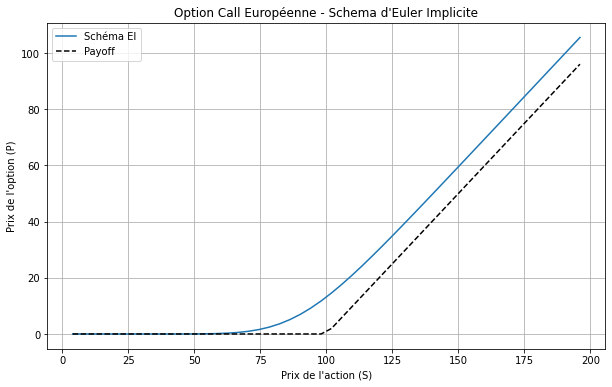

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Paramètres donnés
K, Smin, Smax, T, sigma, r = 100, 0, 200, 1, 0.2, 0.1
I, N = 50, 10
dt, dx = T/N, (Smax - Smin) / (I + 1)

# Fonctions
u0 = lambda s: np.maximum(s - K, 0)
u_left = lambda t: 0
u_right = lambda t: Smax - K * np.exp(-r * t)

# Valeurs spatiales et initialisation
s_values = Smin + np.arange(1, I + 1) * dx
U = u0(s_values)

# Construction de la matrice A
diagonal = sigma**2 * s_values**2 / dx**2 + r
lower = -sigma**2 * s_values**2 / (2 * dx**2) + r * s_values / (2 * dx)
upper = -sigma**2 * s_values**2 / (2 * dx**2) - r * s_values / (2 * dx)
A_ = diags([lower[1:], diagonal, upper[:-1]], [-1, 0, 1], shape=(I, I)).tocsc()

# Boucle principale
for n in range(N):
    t = n * dt
    q = np.zeros(I)
    q[0] = lower[0] * u_left(t + dt)
    q[-1] = upper[-1] * u_right(t + dt)
    U = spsolve(A_ + (1/dt) * diags([1.0]*I), (1/dt)*U - q)

# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.plot(s_values, U, label='Schéma EI')
plt.plot(s_values, u0(s_values), 'k--', label='Payoff')
plt.title("Option Call Européenne - Schema d'Euler Implicite")
plt.xlabel('Prix de l\'action (S)')
plt.ylabel('Prix de l\'option (P)')
plt.legend()
plt.grid(True)
plt.show()

